In [1]:
from IPython.display import display, Markdown

In [2]:
display(Markdown("# Analysis of recent coronavirus data for different countries and regions"))

display(Markdown("### Table of contents"))

display(Markdown("[General Statistics](#General-statistics)"))
display(Markdown("[List of most affected countries](#List-of-most-affected-countries)"))
display(Markdown("[Global situation](#Global-situation)"))
display(Markdown("[Evolution of cases](#Evolution-of-cases)"))
display(Markdown("[Europe](#Europe)"))
display(Markdown("[United States](#United-States)"))
display(Markdown("[Comparison of different countries](#Comparison-of-different-countries)"))
display(Markdown("[Early onset: China regions](#Early-onset:-China-regions)"))
display(Markdown("[Other countries in Asia](#Other-countries-in-Asia)"))

# Analysis of recent coronavirus data for different countries and regions

### Table of contents

[General Statistics](#General-statistics)

[List of most affected countries](#List-of-most-affected-countries)

[Global situation](#Global-situation)

[Evolution of cases](#Evolution-of-cases)

[Europe](#Europe)

[United States](#United-States)

[Comparison of different countries](#Comparison-of-different-countries)

[Early onset: China regions](#Early-onset:-China-regions)

[Other countries in Asia](#Other-countries-in-Asia)

In [3]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import curve_fit
import datetime
import matplotlib.dates as mdates
from IPython.display import display, Markdown
from matplotlib.ticker import ScalarFormatter
#from scipy.interpolate import interp1d
from scipy.signal import savgol_filter


In [4]:
today = datetime.datetime.today().strftime('%A %d %B %Y')
display(Markdown(f"#### Updated on {today}"))
display(Markdown("Author: Javier Moldon"))
display(Markdown("More info in [https://github.com/jmoldon/coronavirus_analysis](https://github.com/jmoldon/coronavirus_analysis)"))
display(Markdown("link to this report: [https://jmoldon.github.io/coronavirus_analysis/cvid_report.html](https://jmoldon.github.io/coronavirus_analysis/cvid_report.html)"))


#### Updated on Monday 23 March 2020

Author: Javier Moldon

More info in [https://github.com/jmoldon/coronavirus_analysis](https://github.com/jmoldon/coronavirus_analysis)

link to this report: [https://jmoldon.github.io/coronavirus_analysis/cvid_report.html](https://jmoldon.github.io/coronavirus_analysis/cvid_report.html)

> "No matter how much you talk about them or think about them, you will still underestimate exponentials".  
Jeremy Howard

In [5]:
matplotlib.rcParams["figure.figsize"] = 12,8
import warnings
do_debug = False
if not do_debug:
    warnings.filterwarnings('ignore')
    #warnings.filterwarnings('default')

In [6]:
display(Markdown("# General statistics"))

display(Markdown("Data comes from Johns Hopkins University at https://github.com/CSSEGISandData/COVID-19 that is updated daily."))

# General statistics

Data comes from Johns Hopkins University at https://github.com/CSSEGISandData/COVID-19 that is updated daily.

In [7]:
# import data from github url, url1 -Confirmed, url2 -Deaths. url3 -Recovered
if True:
    filetags = ['Confirmed', 'Deaths', 'Recovered']
    for filetag in filetags:
        url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-'+filetag+'.csv'
        filename = os.path.basename(url)
        command1 = f'curl -o {filename} {url}'
        os.system(command1)
        os.system(f'mv {filename} ./data/')

data_path = './data/'
file1 = data_path + 'time_series_19-covid-Confirmed.csv'
file2 = data_path + 'time_series_19-covid-Deaths.csv'
file3 = data_path + 'time_series_19-covid-Recovered.csv'

df1 = pd.read_csv(file1, error_bad_lines=False)
df2 = pd.read_csv(file2, error_bad_lines=False)
df3 = pd.read_csv(file3, error_bad_lines=False)

#display(df1.head(), df2.head(), df3.head())

In [8]:
# Convert date columns to a time series
df1u = pd.melt(df1, id_vars=['Province/State', 'Country/Region', 'Lat','Long'], var_name='DateTime', value_name='Confirmed')
df2u = pd.melt(df2, id_vars=['Province/State', 'Country/Region', 'Lat','Long'], var_name='DateTime', value_name='Deaths')
df3u = pd.melt(df3, id_vars=['Province/State', 'Country/Region', 'Lat','Long'], var_name='DateTime', value_name='Recovered')

df1u['DateTime'] = pd.to_datetime(df1u['DateTime'])
df2u['DateTime'] = pd.to_datetime(df2u['DateTime'])
df3u['DateTime'] = pd.to_datetime(df3u['DateTime'])

data = pd.concat([df1u, df2u, df3u], axis=1, join='inner')
data = data.loc[:,~data.columns.duplicated()] # Remove columns that were repeated in the three datasets
data['Active'] = data['Confirmed']-data['Deaths']-data['Recovered']
data['mortality_fraction'] = data['Deaths']/data['Confirmed']
data['Province/State'][data['Province/State'].isna()] = ''

for column in ['Confirmed', 'Deaths', 'Recovered', 'Active']:
    data[column+'_diff'] = data.groupby(['Country/Region', 'Province/State'])[column].apply(lambda x:x.diff())

# data per country
data_c = data.groupby(['DateTime','Country/Region']).sum().reset_index()

In [9]:
#Example table:
#data[['Country/Region','Confirmed','Deaths','Recovered']]

In [10]:
#I need to remove a few points manually that I identified as bad ones
data.drop(data[(data['Country/Region']=='Spain') & (data['DateTime'] == datetime.datetime.strptime('2020-03-12', '%Y-%m-%d'))].index, inplace=True)
data.drop(data[(data['Country/Region']=='Italy') & (data['DateTime'] == datetime.datetime.strptime('2020-03-12', '%Y-%m-%d'))].index, inplace=True)
data.drop(data[(data['Country/Region']=='Netherlands') & (data['DateTime'] == datetime.datetime.strptime('2020-03-12', '%Y-%m-%d'))].index, inplace=True)
data.drop(data[(data['Country/Region']=='United Kingdom') & (data['Province/State']=='United Kingdom') & (data['DateTime'] == datetime.datetime.strptime('2020-03-12', '%Y-%m-%d'))].index, inplace=True)
data.drop(data[(data['Country/Region']=='United Kingdom') & (data['Province/State']=='United Kingdom') & (data['DateTime'] == datetime.datetime.strptime('2020-03-13', '%Y-%m-%d'))].index, inplace=True)
data.drop(data[(data['Country/Region']=='United Kingdom') & (data['Province/State']=='United Kingdom') & (data['DateTime'] == datetime.datetime.strptime('2020-03-15', '%Y-%m-%d'))].index, inplace=True)

## List of most affected countries

Sorted by highest number of deaths in the previous day

In [11]:
most_cases_c = data_c.loc[data_c.groupby(['Country/Region'])['DateTime'].idxmax()].sort_values(by='Deaths_diff')[::-1][0:25]
columns = ['Deaths', 'Confirmed', 'Recovered', 'Active']
for column in columns:
    most_cases_c[column] = most_cases_c.apply(lambda row: f"{row[column]} ({row[column+'_diff']:+.0f})", axis=1)
display(most_cases_c[['Country/Region']+columns].set_index('Country/Region'))

,Deaths,Confirmed,Recovered,Active
Country/Region,,,,
Italy,5476 (+651),59138 (+5560),7024 (+952),46638 (+3957)
Spain,1772 (+397),28768 (+3394),2575 (+450),24421 (+2547)
Iran,1685 (+129),21638 (+1028),7931 (+296),12022 (+603)
France,674 (+112),16176 (+1745),2206 (+2194),13296 (-561)
US,417 (+110),33272 (+7783),0 (+0),32855 (+7673)
United Kingdom,282 (+48),5741 (+674),67 (+0),5392 (+626)
Netherlands,180 (+43),4216 (+576),2 (+0),4034 (+533)
Switzerland,98 (+23),7245 (+670),131 (+116),7016 (+531)
Turkey,30 (+21),1236 (+566),0 (+0),1206 (+545)


## List of most affected States in the USA

Sorted by highest number of deaths in the previous day

In [12]:
usa = data[data['Country/Region']=='US']
most_cases = usa.loc[usa.groupby(['Province/State'])['DateTime'].idxmax()].sort_values(by='Deaths_diff')[::-1][0:10].set_index(['Province/State'])

columns = ['Deaths', 'Confirmed', 'Recovered', 'Active']
for column in columns:
    most_cases[column] = most_cases.apply(lambda row: f"{row[column]} (+{row[column+'_diff']:.0f})", axis=1)
display(most_cases[columns])

,Deaths,Confirmed,Recovered,Active
Province/State,,,,
New York,117 (+57),15793 (+4083),0 (+0),15676 (+4026)
Georgia,23 (+9),600 (+93),0 (+0),577 (+84)
California,30 (+6),1642 (+278),0 (+0),1612 (+272)
Virginia,6 (+4),221 (+65),0 (+0),215 (+61)
New Jersey,20 (+4),1914 (+587),0 (+0),1894 (+583)
Louisiana,20 (+4),837 (+252),0 (+0),817 (+248)
Massachusetts,5 (+4),646 (+121),0 (+0),641 (+117)
Michigan,9 (+4),1037 (+249),0 (+0),1028 (+245)
Illinois,9 (+3),1049 (+296),0 (+0),1040 (+293)


In [13]:
def select_country(data, country='', province='', start_date='2020-01-01', end_date='2021-12-31'):
    # Select by country
    if country != '':
        cond1 = data['Country/Region'] == country
    else:
        cond1 = data['Country/Region'].notna()  # Select any country
    # Select by province
    if province != '':
        cond2 = data['Province/State'] == province
    else:
        cond2 = data['Province/State'] != np.nan  # Select any province
    # Select by time range
    if start_date != '':
        t0 = datetime.datetime.strptime(start_date, '%Y-%m-%d')
    else:
        t0 = datetime.datetime.strptime('2000-01-01', '%Y-%m-%d')
    if end_date != '':
        t1 = datetime.datetime.strptime(end_date, '%Y-%m-%d')
    else:
        t1 = datetime.datetime.strptime('9999-01-01', '%Y-%m-%d')
    cond3 = (data['DateTime'] >= t0) & (data['DateTime'] < t1)
    selection = cond1&cond2&cond3
    if do_debug:
        print('Number of entries per country: {}'.format(cond1.sum()))
        print('Number of entries per province: {}'.format(cond2.sum()))
        print('Number of entries per time range: {}'.format(cond3.sum()))
        print('Number of entries selected: {}'.format(selection.sum()))
    return data[selection]

# Global situation

These plots show the global situation of the countries with higher number of deaths.

### Deaths

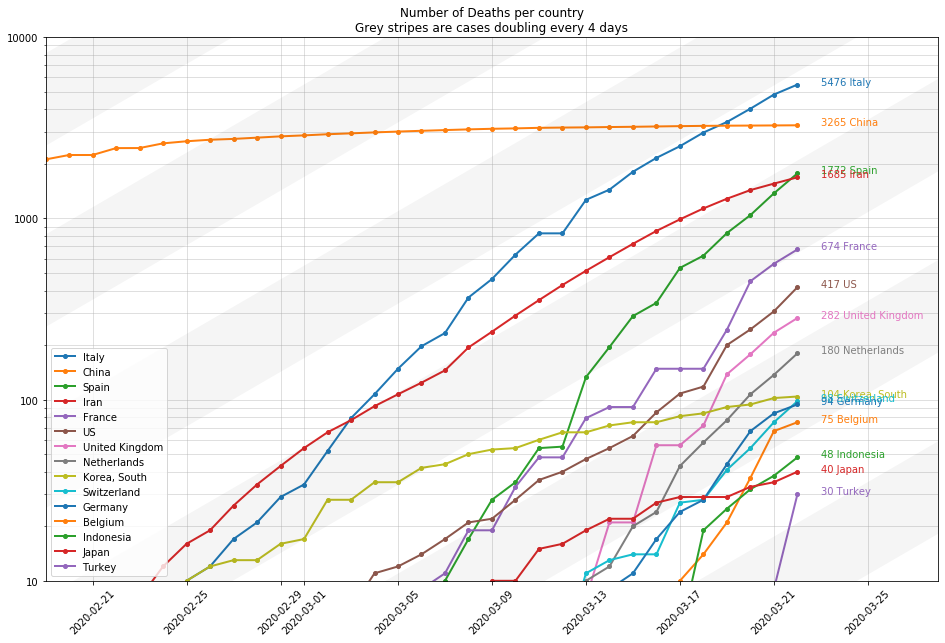

In [14]:
display(Markdown('### Deaths'))

most_cases_c = data_c.loc[data_c.groupby(['Country/Region'])['DateTime'].idxmax()].sort_values(by='Deaths')[::-1]

fig = plt.figure(figsize=(16, 10))
ax1 = plt.subplot2grid((1,1), (0, 0))

for c in most_cases_c['Country/Region'].iloc[0:15]: 
    my_country = data_c[data_c['Country/Region']==c]
    l = ax1.plot(my_country['DateTime'], my_country['Deaths'], 'o-', ms=4, label=c, lw=2)
    ax1.annotate(f"{my_country['Deaths'].iloc[-1]} {c}",
                     (my_country['DateTime'].iloc[-1]+datetime.timedelta(days=1),my_country['Deaths'].iloc[-1]), color=l[0].get_color())
    
t = my_country['DateTime']
n = 4 # days to double
for j in np.arange(-7,10):
    ax1.plot(t+datetime.timedelta(days=6), np.array([10.**j*2**(i/n) for i, ti in enumerate(t)]), '-k', alpha=0.04, lw=80)
    
ax1.legend(loc='lower left')
ax1.set_yscale('log')
ax1.set_ylim(10, 10000)
ax1.set_xlim(my_country['DateTime'].iloc[0]+datetime.timedelta(days=28), my_country['DateTime'].iloc[-1]+datetime.timedelta(days=6))
ax1.set_title(f'Number of Deaths per country\nGrey stripes are cases doubling every {n} days');

formatter = ScalarFormatter()
formatter.set_scientific(False)
ax1.yaxis.set_major_formatter(formatter)
    
ax1.xaxis.set_tick_params(rotation=45)
ax1.grid(which='both', alpha=0.5)

fig.savefig(f'./plots/most_deaths_evolution.png', bbox_inches='tight', dpi=100)

### Confirmed Cases

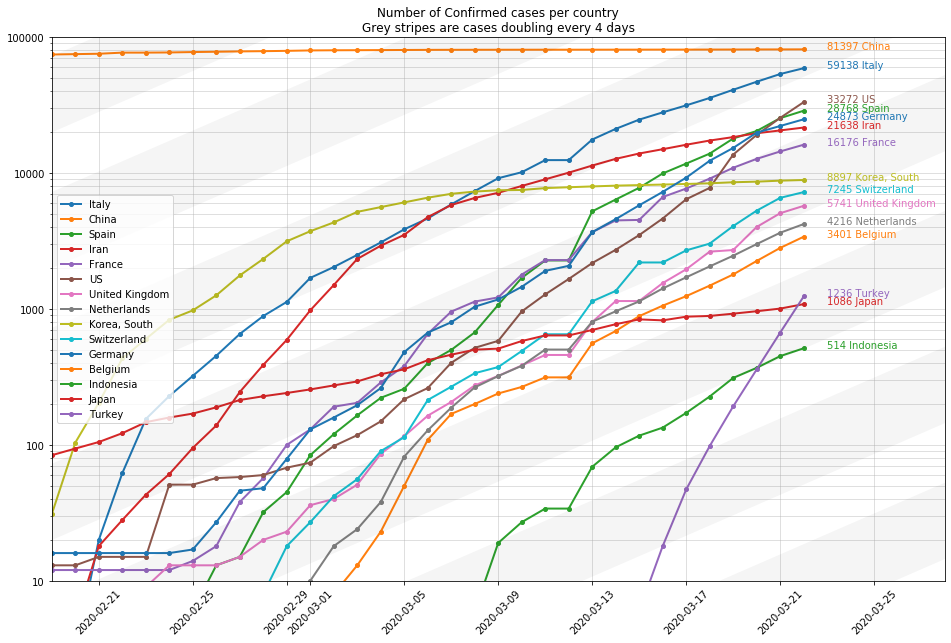

In [15]:
display(Markdown('### Confirmed Cases'))

fig = plt.figure(figsize=(16, 10))
ax1 = plt.subplot2grid((1,1), (0, 0))

for c in most_cases_c['Country/Region'].iloc[0:15]: 
    my_country = data_c[data_c['Country/Region']==c]
    l = ax1.plot(my_country['DateTime'], my_country['Confirmed'], 'o-', ms=4, label=c, lw=2)
    ax1.annotate(f"{my_country['Confirmed'].iloc[-1]} {c}",
                     (my_country['DateTime'].iloc[-1]+datetime.timedelta(days=1),my_country['Confirmed'].iloc[-1]), color=l[0].get_color())

t = my_country['DateTime'][1:]
n = 4 # days to double
for j in np.arange(-8,10):
    ax1.plot(t+datetime.timedelta(days=6), np.array([10.**j*2**(i/n) for i, ti in enumerate(t)]), '-k', alpha=0.04, lw=70)

ax1.legend(loc='center left')
ax1.set_yscale('log')
ax1.set_ylim(10, 100000)
ax1.set_xlim(my_country['DateTime'].iloc[0]+datetime.timedelta(days=28), my_country['DateTime'].iloc[-1]+datetime.timedelta(days=6))
ax1.set_title(f'Number of Confirmed cases per country\nGrey stripes are cases doubling every {n} days');

formatter = ScalarFormatter()
formatter.set_scientific(False)
ax1.yaxis.set_major_formatter(formatter)
    
ax1.xaxis.set_tick_params(rotation=45)
ax1.grid(which='both', alpha=0.5)

fig.savefig(f'./plots/most_cases_evolution.png', bbox_inches='tight', dpi=100)

In [16]:
def plot_country(data_country, prediction, ylim=1e5, death_lim=900, n=4):
    gridsize = (4, 2)
    fig = plt.figure(figsize=(18, 12))
    ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=1, rowspan=2)
    ax2 = plt.subplot2grid(gridsize, (0, 1), rowspan=2)
    ax3 = plt.subplot2grid(gridsize, (2, 0), colspan=1, rowspan=2)
    ax4 = plt.subplot2grid(gridsize, (2, 1), colspan=1, rowspan=2)
    plt.subplots_adjust(hspace=0.7)

    axs = [ax1,ax2,ax3, ax4]

    colors = {'Confirmed': '#3498db',
              'Deaths': 'tomato',
              'Recovered': 'g',
               'Active': 'k'}
    for ax in [ax1,ax2]:
        ax.plot(data_country['DateTime'], data_country['Confirmed'], 'o', color=colors['Confirmed'], label='Confirmed')
        ax.plot(data_country['DateTime'], data_country['Deaths'],    'o', color=colors['Deaths'], label='Deaths')
        ax.plot(data_country['DateTime'], data_country['Recovered'], 'o', color=colors['Recovered'], label='Recovered')
        ax.plot(data_country['DateTime'], data_country['Active'],    'o', color=colors['Active'], label='Active')    
        ax.plot(data_country['DateTime'], data_country['Recovered_fit'], '-', color=colors['Recovered'])
        ax.plot(data_country['DateTime'], data_country['Confirmed_fit'], '-', color=colors['Confirmed'])
        ax.plot(data_country['DateTime'], data_country['Deaths_fit'],    '-', color=colors['Deaths'])
        # Model and prediction
        for column in ['Confirmed', 'Deaths', 'Recovered']:
            ax.plot(prediction['DateTime'], prediction[column+'_pred'], '--', color=colors[column])
            ax.fill_between(prediction['DateTime'], prediction[column+'_pred_upper'], prediction[column+'_pred_lower'], color=colors[column], alpha=0.5)
        if n!=0:
            #Doubling rate every n days
            t = prediction['DateTime']
            ax1.set_title(f'Grey stripes are cases doubling every {n} days')
            for j in np.arange(-10,15, 1):
                ax1.plot(t, np.array([10.**j*2**(i/n) for i, ti in enumerate(t)]), '-k', alpha=0.03, lw=25)
    # Active
    active_fit = data_country['Confirmed_fit']-data_country['Recovered_fit']-data_country['Deaths_fit']
    active_pred = prediction['Confirmed_pred']-prediction['Recovered_pred']-prediction['Deaths_pred']    
    for ax in [ax1,ax2]:
        ax.plot(data_country['DateTime'], active_fit,                '-', color=colors['Active'])    
        ax.plot(prediction['DateTime'], active_pred, '--', color=colors['Active'])

    # Death increase
    death_diff = data_country[['DateTime', 'Deaths', 'Deaths_diff']]
    death_diff.drop(death_diff[death_diff['Deaths_diff']==0].index, inplace=True)
    death_diff['timespan'] = death_diff['DateTime'].diff()/ np.timedelta64(1, 'D')
    death_diff['deaths_per_day'] =  death_diff['Deaths_diff']/death_diff['timespan'] 
    dd = death_diff['deaths_per_day'].values
    dd[np.isnan(dd)]=0
    for ax in [ax3,ax4]:
        ax.plot(death_diff['DateTime'], death_diff['deaths_per_day'], drawstyle='steps', color='tomato', lw=3, label='Deaths per day')
        ax.fill_between(death_diff['DateTime'], death_diff['deaths_per_day'], step="pre", color='tomato', alpha=0.4)
        ax.plot(death_diff['DateTime'], savgol_filter(dd, 3, 1), 'k-', label='Smooth')  
    
    ax1.set_ylim(2,ylim)
    #ax2.set_ylim(0,ylim)
    #ax3.set_ylim(0.3, np.nanmax([10, int(np.max(1.5*data_country['Deaths_diff']))]))
    #ax4.set_ylim(0, np.nanmax([10, int(np.max(1.5*data_country['Deaths_diff']))]))
    ax3.set_ylim(0.3, death_lim)
    ax4.set_ylim(0, death_lim)
    
    ax1.set_ylabel('Number of cases (log scale)')
    ax2.set_ylabel('Number of cases (linear scale)')
    ax3.set_ylabel('Deaths per day (log scale)')
    ax4.set_ylabel('Deaths per day (linear scale)')
    
    for axi in axs:
        axi.xaxis.set_tick_params(rotation=45)
        axi.grid(which='both', alpha=0.3)
        axi.legend()
        axi.set_xlim(data_country['DateTime'].iloc[0], prediction['DateTime'].iloc[-1])

    
    country = data_country['Country/Region'].unique()[0]
    province = data_country['Province/State'].unique()[0]
    start_date = data_country['DateTime'].iloc[0]
    end_date = data_country['DateTime'].iloc[-1]
    fig.suptitle(f"{country} {province}\nDate range: {start_date.strftime('%d %m %Y')} to {end_date.strftime('%d %m %Y')}", fontsize=16)
    #ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax3.set_yscale('log')
    formatter = ScalarFormatter()
    formatter.set_scientific(False)
    ax1.yaxis.set_major_formatter(formatter)
    ax3.yaxis.set_major_formatter(formatter)

    fig.savefig(f'./plots/{country}{province}.png', bbox_inches='tight', dpi=100)
    return fig, axs

In [17]:
# Functions to fit models to the data, including predictions and confidence interval

# For few data points, the exponential benefits from fixing the reference data.
# I could use x[0], but then I cannot compute the upper/lower bounds for each data
# point using the same model, so I fix t0
t0 = 737476.0

def func_exponential(x,  b, alpha):
    return  b * np.exp(alpha * (x-t0))

def func_logistic(x, L, k, x0):
    return L/(1+np.exp(-k*(x-x0)))

def calc_goodness(x, y, func, popt):
    # residual sum of squares
    y_fit = func(x, *popt)
    ss_res = np.sum((y - y_fit) ** 2)
    # total sum of squares
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    # r-squared
    r2 = 1 - (ss_res / ss_tot)
    return r2

def read_fit(popt, pcov, x, y, func, name):
    fit = {}
    fit['popt'] = popt
    fit['pcov'] = pcov
    fit['popt_err'] = np.sqrt(np.diag(pcov))
    fit['goodness'] = calc_goodness(x,y,func,popt)
    fit['func'] = func
    fit['name'] = name
    return fit
    
def choose_optimal_fit(fits):
    fit_names = fits.keys()
    best_goodness = -9999
    for name in fit_names:
        if fits[name]['goodness'] > best_goodness:
            best_goodness = fits[name]['goodness']
            best_fit = fits[name]
    return best_fit

def calc_ci(popt, pcov, xx, func, N=1000):
    popt_err = np.sqrt(np.diagonal(pcov))
    params_sim = np.empty((len(popt), N))
    for i, (p, p_err) in enumerate(zip(popt, popt_err)):
        params_sim[i] = np.random.normal(p, p_err, N)
    y_err = np.empty_like(xx)
    upper_bound = np.empty_like(xx)
    lower_bound = np.empty_like(xx)
    for i, xi in enumerate(xx):
        y_err[i] = np.std(func(xi, *params_sim))
        upper_bound[i] = func(xi, *popt) + y_err[i]
        lower_bound[i] = func(xi, *popt) - y_err[i]
    return upper_bound, lower_bound, y_err

def print_best_fit(best_fit):
    print()
    print('best', best_fit['name'], best_fit['goodness'])
    print('popt     ', best_fit['popt'])
    print('popt_err ', best_fit['popt_err'])
    print('popt_err/popt ', best_fit['popt_err']/best_fit['popt'])

def fit_data(data, future_d=5, fits_todo={}, p0={}, min_y={}, threshold={}):
    if fits_todo == {}:
        fits_todo = {'Confirmed': [func_exponential, func_logistic],
                     'Deaths':    [func_exponential, func_logistic],
                     'Recovered': [func_exponential, func_logistic]
                    }
    if min_y == {}:
        min_y = {'Confirmed': 20,
                 'Deaths': 2,
                 'Recovered': 5
                }
    x = mdates.date2num(data['DateTime'])
    # Prepare dates for prediction that will go to the "prediction" dataframe
    dates_pred = pd.date_range(start=data['DateTime'].iloc[0], end=data['DateTime'].iloc[-1]+datetime.timedelta(days=future_d))
    prediction = pd.DataFrame({'DateTime':dates_pred})
    xx = mdates.date2num(dates_pred)
    for column in fits_todo.keys():
        if do_debug: print('\nColumn: ',column)
        y = data[column].values
        my_fits = {}
        cond = data[column] > min_y[column]
        # The default parameter guessing depends on the data, y
        p_guess_default = {func_exponential: [np.max(y), 0.3],
                           func_logistic:    [np.max(y), 0.3, np.mean(x)]}
        if do_debug: print('p_guess_default: ', p_guess_default)
        for func in fits_todo[column]:
            name = func.__name__
            # Compute some initial guessings per function
            if column in p0.keys():
                pguess = p0[column].get(func, p_guess_default[func])
            else:
                pguess = p_guess_default[func]
            if do_debug: print('pguess ', pguess)
            try:            
                popt, pcov = curve_fit(func, x, y, p0=pguess)
                my_fits[name] = read_fit(popt, pcov, x[cond], y[cond], func, name)
                if do_debug: print(my_fits[name])
            except RuntimeError:
                if do_debug: print(f'Fit {name} did not converge')
        if any([v['goodness']>0. for k,v in my_fits.items()]): # Means at least one fit was successful
            best_fit = choose_optimal_fit(my_fits)
            if do_debug:
                print_best_fit(best_fit)
            # Fill main dataframe with best fit
            data.loc[:, column+'_fit'] = best_fit['func'](x, *best_fit['popt'])
            # Fill prediction with best fit prediction
            upper_bound, lower_bound, y_err = calc_ci(best_fit['popt'], best_fit['pcov'], xx, best_fit['func'])
            prediction[column+'_pred'] = best_fit['func'](xx, *best_fit['popt'])
            prediction[column+'_pred_upper'] = upper_bound
            prediction[column+'_pred_lower'] = lower_bound
            # With low number of data points the error can be huge, I will remove the
            # confidence interval when any of the fitted parameters have huge errors:
            bound_threshold = threshold.get(column, 0.6)
            if ((best_fit['popt_err']/best_fit['popt']) > bound_threshold).any():
                prediction[column+'_pred_upper'] *= np.nan
                prediction[column+'_pred_lower'] *= np.nan
        else:  # Could not find any solution
            data.loc[:, column+'_fit'] = np.nan
            prediction[column+'_pred'] = np.nan
            prediction[column+'_pred_upper'] = np.nan
            prediction[column+'_pred_lower'] = np.nan
    return data, prediction

#display(Markdown("$y(t)=\\frac{L}{1+ e^{-k(t-t0)}}$"))

In [18]:
def print_table(my_country, prediction, days=5):
    display(Markdown(f"#### Current today"))
    my_country['Date (end of)'] = my_country['DateTime'].dt.strftime('%a %d %B %Y')
    display(my_country[['Date (end of)', 'Confirmed', 'Deaths', 'Recovered']].iloc[-1:].style.hide_index())
    
    to_show = prediction[['DateTime', 'Confirmed_pred', 'Deaths_pred', 'Recovered_pred']][-days:]
    to_show['DateTime'] = to_show['DateTime'].dt.strftime('%a %d %B %Y')
    to_show.columns = ['Date (end of)', 'Confirmed', 'Deaths', 'Recovered']
    display(Markdown(f"#### {days} day prediction"))
    display(to_show.style.format({'Confirmed':"{:.0f}", 'Deaths':"{:.0f}", 'Recovered':"{:.0f}"}).hide_index())

In [19]:
def process_country(data, country='Spain', province='', start_date='2020-01-15', end_date='2021-03-12'):
    my_country = select_country(data, country=country, province=province, start_date=start_date, end_date=end_date)
    data_country, prediction = fit_data(my_country)
    fig, ax = plot_country(data_country, prediction)
    return data_country, prediction, fig, ax


## World (except China)

#### Current today

Date (end of),Confirmed,Deaths,Recovered
Sun 22 March 2020,254558,11367,25342


#### 5 day prediction

Date (end of),Confirmed,Deaths,Recovered
Mon 23 March 2020,304773,14149,27852
Tue 24 March 2020,358215,17156,32433
Wed 25 March 2020,421028,20801,37769
Thu 26 March 2020,494856,25222,43983
Fri 27 March 2020,581630,30582,51219


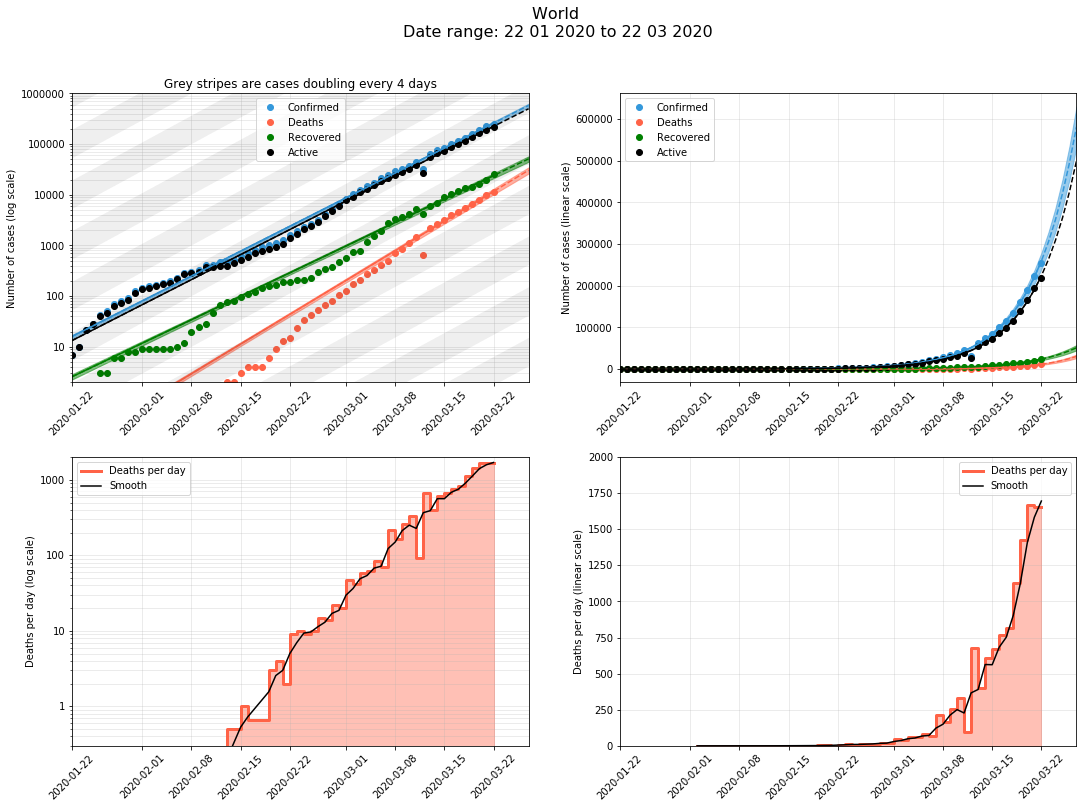

In [20]:
display(Markdown("## World (except China)"))
world_data = data[data['Country/Region']!='China']
all_countries = world_data.groupby(['DateTime']).sum().reset_index()
all_countries['Country/Region'] = 'World'
all_countries['Province/State'] = ''
fits_todo1 = {'Confirmed': [func_exponential],
             'Deaths':     [func_exponential],
             'Recovered':  [func_exponential]}

data_country, prediction = fit_data(all_countries, fits_todo=fits_todo1)
fig, ax = plot_country(data_country, prediction, ylim=1000000, death_lim=2000)
print_table(data_country, prediction, days=5)

## China

#### Current today

Date (end of),Confirmed,Deaths,Recovered
Sun 22 March 2020,81397,3265,72362


#### 5 day prediction

Date (end of),Confirmed,Deaths,Recovered
Mon 23 March 2020,80975,3206,71531
Tue 24 March 2020,80976,3208,71813
Wed 25 March 2020,80977,3209,72058
Thu 26 March 2020,80977,3210,72270
Fri 27 March 2020,80978,3211,72454


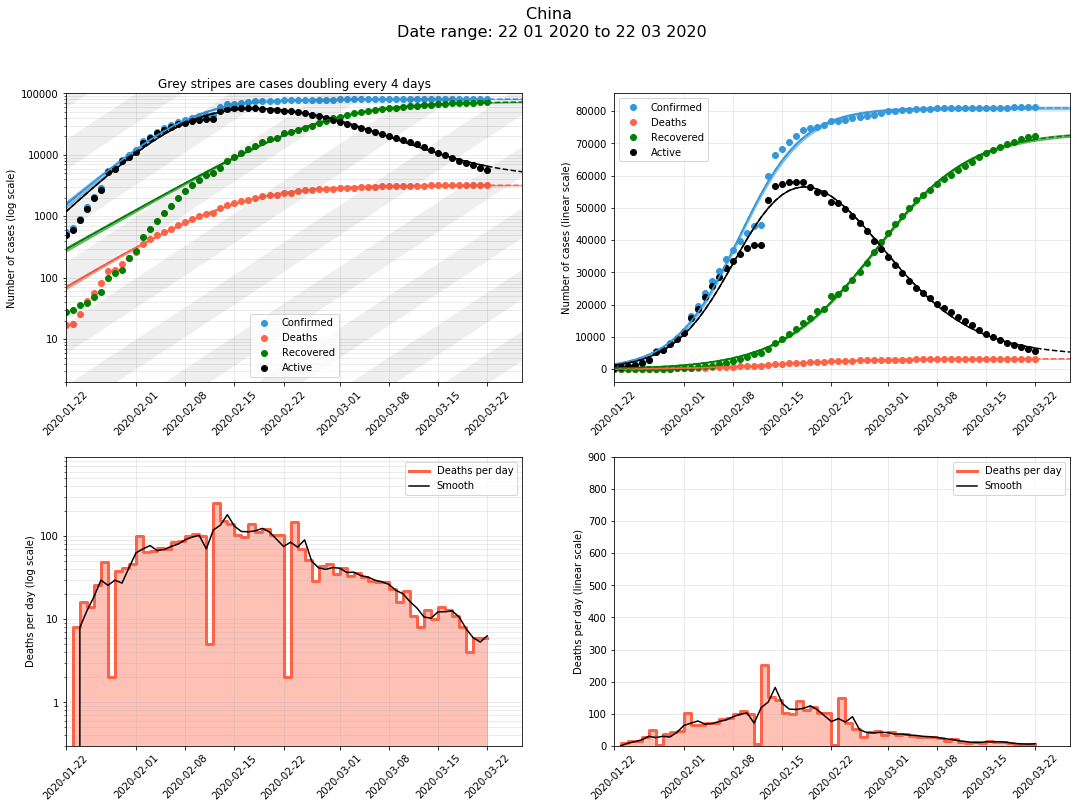

In [21]:
display(Markdown("## China"))
china_data = data[data['Country/Region']=='China']
china = china_data.groupby(['DateTime']).sum().reset_index()
china['Country/Region'] = 'China'
china['Province/State'] = ''
data_country, prediction = fit_data(china)
fig, ax = plot_country(data_country, prediction)
print_table(data_country, prediction, days=5)

# Evolution of cases

All plots have the same information. Left: log scale, right: linear scale. Bottom-right: is a zoom to show the correct scale for deaths. The straight line is a fit to a logistic growth when possible. If the fit does not converge (low number of points in early stages) a simple exponential is used. The dashed line is a prediction based on the fit. 

# Europe

## Spain

I can see a change in the slope of the last few days. However, it is not clear if it is an exponential function with a different growth or the start of change to a logistic growth. I plot both of them. Exponential means worse news.

#### Current today

Date (end of),Confirmed,Deaths,Recovered
Sun 22 March 2020,28768,1772,2575


#### 5 day prediction

Date (end of),Confirmed,Deaths,Recovered
Mon 23 March 2020,36967,2339,3320
Tue 24 March 2020,45139,3056,4220
Wed 25 March 2020,55117,3992,5364
Thu 26 March 2020,67300,5215,6818
Fri 27 March 2020,82176,6813,8666


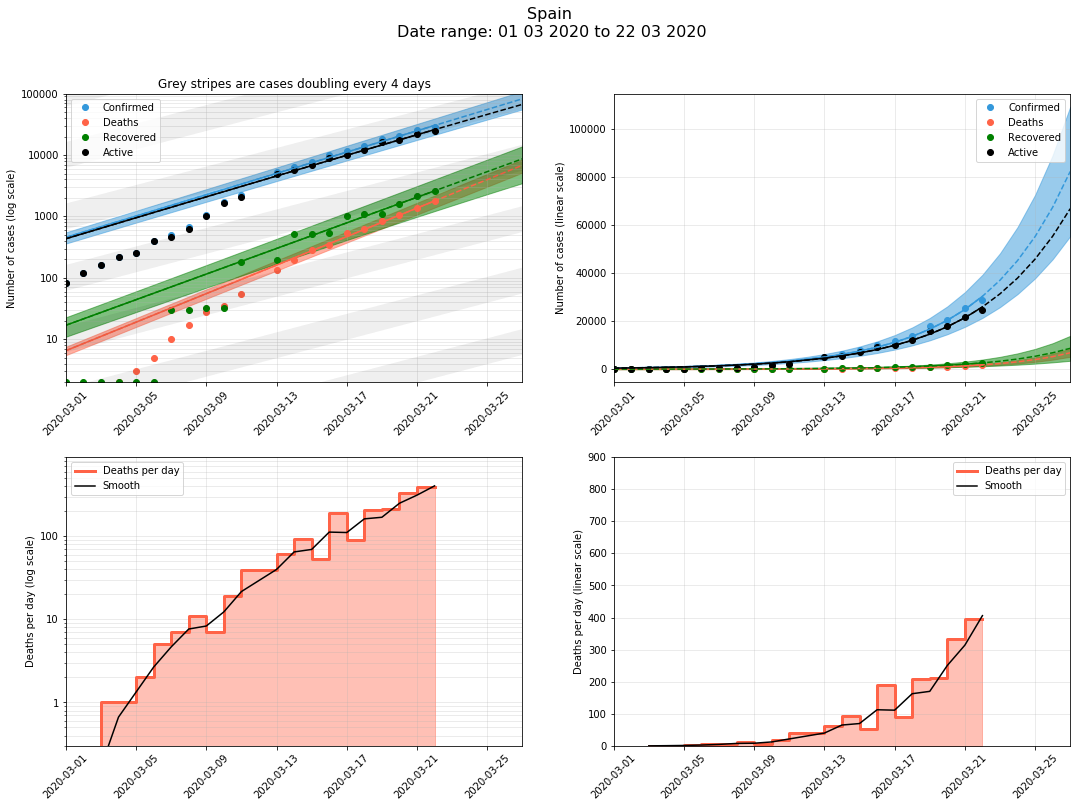

In [22]:
display(Markdown("## Spain"))
display(Markdown("I can see a change in the slope of the last few days. However, it is not clear if it is an exponential function with a different growth or the start of change to a logistic growth. I plot both of them. Exponential means worse news."))
min_y1 = {'Confirmed': 1100, 'Deaths': 100, 'Recovered': 100}
fits_todo1 = {'Confirmed': [func_exponential],
             'Deaths':     [func_exponential],
             'Recovered':  [func_exponential]}
threshold1 = {'Confirmed': 0.9, 'Deaths': 0.8, 'Recovered': 0.4}

my_country = select_country(data, country='Spain', start_date='2020-03-01')
data_country, prediction = fit_data(my_country, min_y = min_y1, fits_todo=fits_todo1, threshold=threshold1)
fig, ax = plot_country(data_country, prediction)

print_table(my_country, prediction, days=5)

## Italy

#### Current today

Date (end of),Confirmed,Deaths,Recovered
Sun 22 March 2020,59138,5476,7024


#### 5 day prediction

Date (end of),Confirmed,Deaths,Recovered
Mon 23 March 2020,64616,6122,8341
Tue 24 March 2020,70359,6810,9871
Wed 25 March 2020,75918,7479,11682
Thu 26 March 2020,81205,8116,13825
Fri 27 March 2020,86148,8706,16361


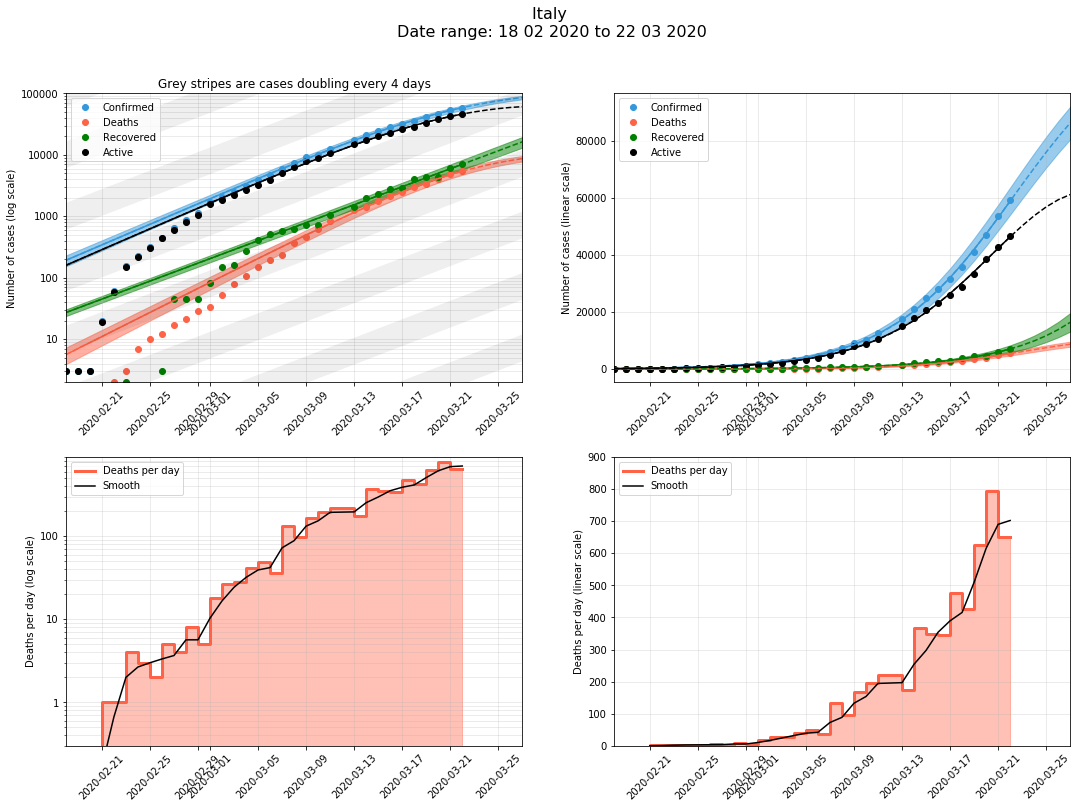

In [23]:
display(Markdown("## Italy"))
min_y1 = {'Confirmed': 10, 'Deaths': 1, 'Recovered': 10}
fits_todo1 = {'Confirmed': [func_exponential, func_logistic],
             'Deaths':     [func_exponential, func_logistic],
             'Recovered':  [func_exponential]}

my_country = select_country(data, country='Italy', start_date='2020-02-18')
data_country, prediction = fit_data(my_country, min_y = min_y1, fits_todo=fits_todo1)
fig, ax = plot_country(data_country, prediction)
print_table(my_country, prediction, days=5)

## France

#### Current today

Date (end of),Confirmed,Deaths,Recovered
Sun 22 March 2020,16018,674,2200


#### 5 day prediction

Date (end of),Confirmed,Deaths,Recovered
Mon 23 March 2020,20371,931,nan
Tue 24 March 2020,24274,1242,nan
Wed 25 March 2020,28926,1658,nan
Thu 26 March 2020,34468,2212,nan
Fri 27 March 2020,41073,2951,nan


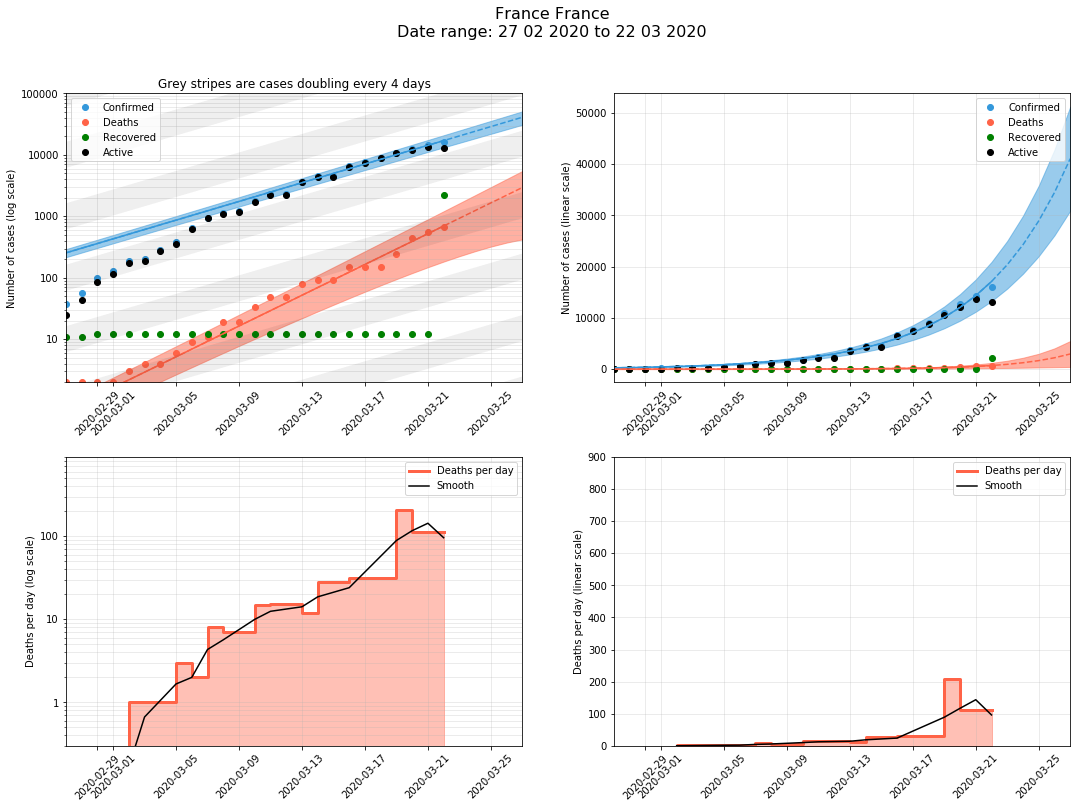

In [24]:
display(Markdown("## France"))
min_y1 = {'Confirmed': 50, 'Deaths': 100, 'Recovered': 2}

fits_todo1 = {'Confirmed': [func_exponential],
             'Deaths':     [func_exponential],
             'Recovered':  [func_exponential]}

threshold1 = {'Confirmed': 0.7, 'Deaths': 0.5}
my_country = select_country(data, country='France',province='France', start_date='2020-02-27')
data_country, prediction = fit_data(my_country, min_y=min_y1, fits_todo=fits_todo1, threshold=threshold1)
fig, ax = plot_country(data_country, prediction)
print_table(my_country, prediction, days=5)


## Germany

#### Current today

Date (end of),Confirmed,Deaths,Recovered
Sun 22 March 2020,24873,94,266


#### 5 day prediction

Date (end of),Confirmed,Deaths,Recovered
Mon 23 March 2020,33299,136,340
Tue 24 March 2020,41166,181,428
Wed 25 March 2020,50892,240,539
Thu 26 March 2020,62916,320,678
Fri 27 March 2020,77781,425,853


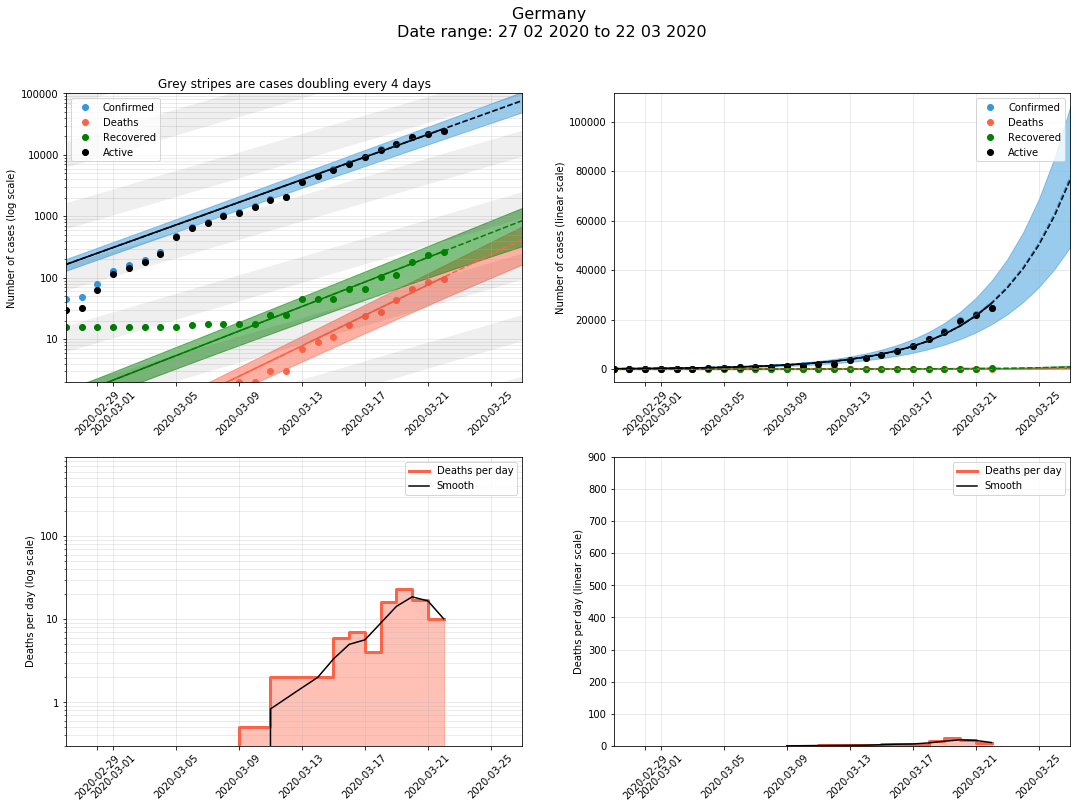

In [25]:
display(Markdown("## Germany"))
min_y1 = {'Confirmed': 50, 'Deaths': 2, 'Recovered': 20}

fits_todo1 = {'Confirmed': [func_exponential],
             'Deaths':     [func_exponential],
             'Recovered':  [func_exponential, func_logistic]}
threshold1 = {'Confirmed': 0.9, 'Deaths': 0.8}

my_country = select_country(data, country='Germany',province='', start_date='2020-02-27')
data_country, prediction = fit_data(my_country, min_y=min_y1, fits_todo=fits_todo1, threshold=threshold1)
fig, ax = plot_country(data_country, prediction)
print_table(my_country, prediction, days=5)

## United Kingdom

#### Current today

Date (end of),Confirmed,Deaths,Recovered
Sun 22 March 2020,5683,281,65


#### 5 day prediction

Date (end of),Confirmed,Deaths,Recovered
Mon 23 March 2020,7325,397,85
Tue 24 March 2020,9113,533,96
Wed 25 March 2020,11337,715,108
Thu 26 March 2020,14103,961,121
Fri 27 March 2020,17545,1290,136


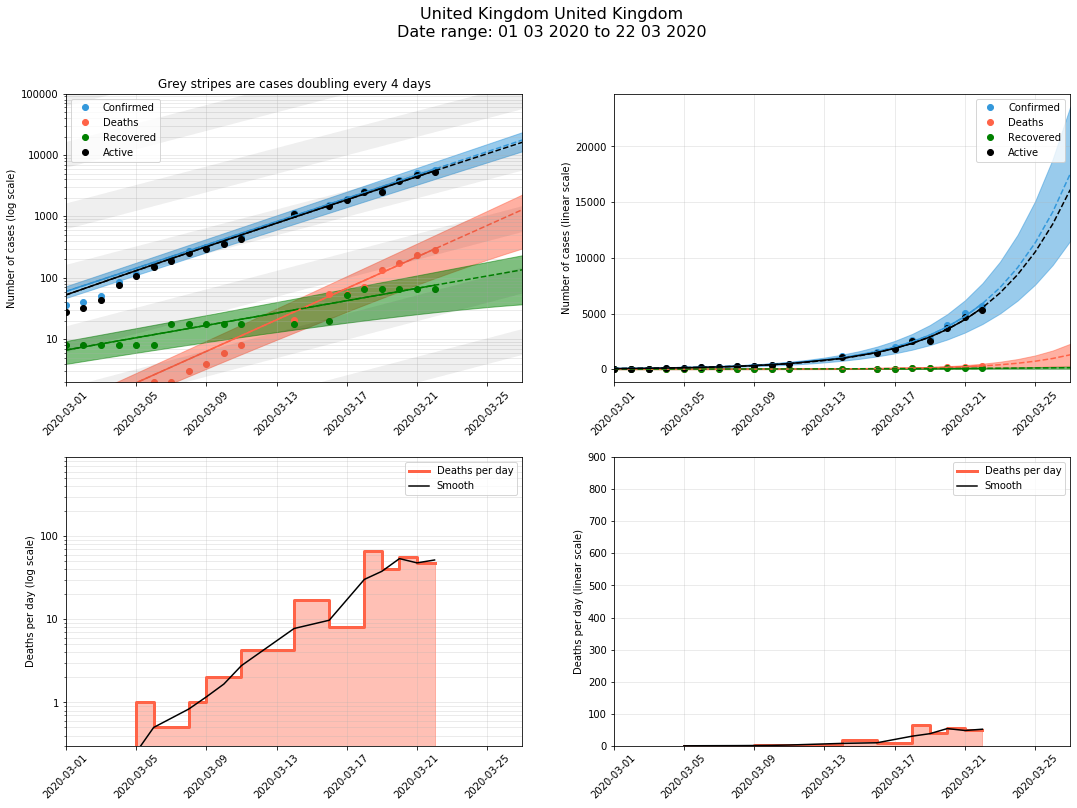

In [26]:
display(Markdown("## United Kingdom"))
min_y1 = {'Confirmed': 50, 'Deaths': 5, 'Recovered': 1}

fits_todo1 = {'Confirmed': [func_exponential],
             'Deaths':     [func_exponential],
             'Recovered':  [func_exponential]}

threshold1 = {'Deaths': 0.1}

my_country = select_country(data, country='United Kingdom',province='United Kingdom', start_date='2020-03-01')
data_country, prediction = fit_data(my_country, min_y=min_y1, fits_todo=fits_todo1)
fig, ax = plot_country(data_country, prediction)
print_table(my_country, prediction, days=5)

## Sweden

#### Current today

Date (end of),Confirmed,Deaths,Recovered
Sun 22 March 2020,1934,21,16


#### 5 day prediction

Date (end of),Confirmed,Deaths,Recovered
Mon 23 March 2020,1900,24,16
Tue 24 March 2020,1958,25,16
Wed 25 March 2020,2005,26,16
Thu 26 March 2020,2042,27,16
Fri 27 March 2020,2072,28,16


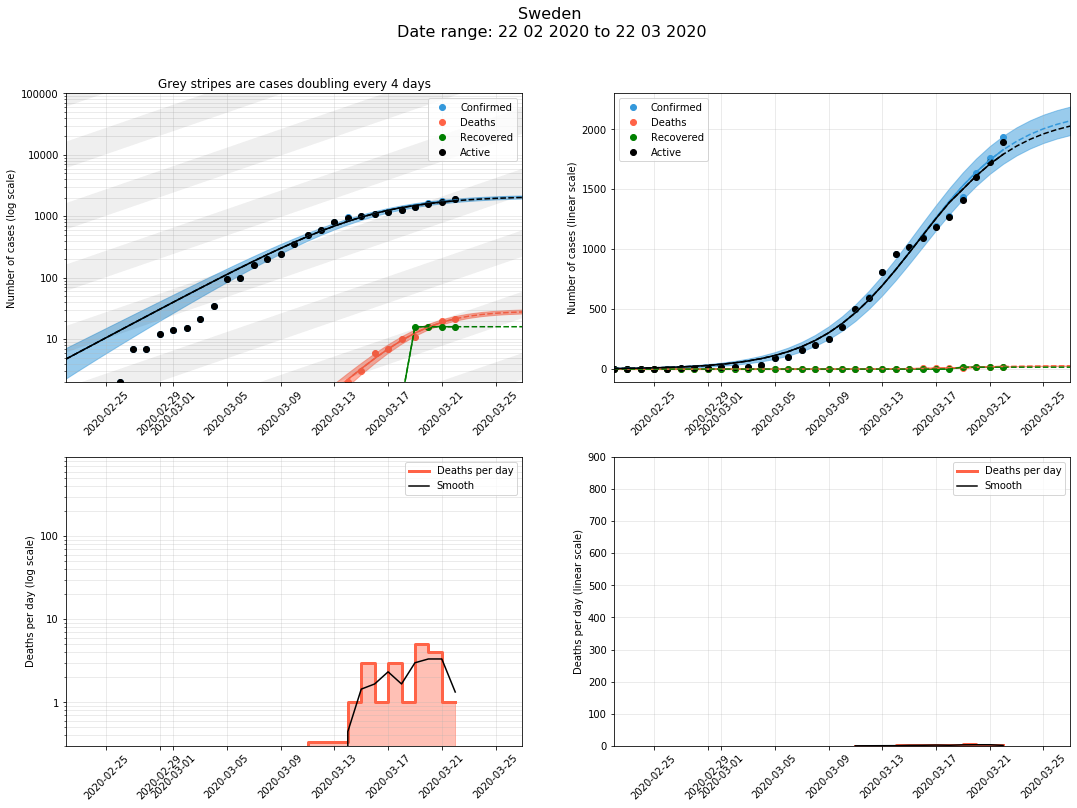

In [27]:
display(Markdown("## Sweden"))
min_y1 = {'Confirmed': 50, 'Deaths': 0, 'Recovered': 0}

fits_todo1 = {'Confirmed': [func_exponential, func_logistic],
             'Deaths':     [func_exponential, func_logistic],
             'Recovered':  [func_exponential, func_logistic]}
threshold1 = {'Confirmed': 0.6, 'Deaths': 0.6}

my_country = select_country(data, country='Sweden',province='', start_date='2020-02-22')
data_country, prediction = fit_data(my_country, min_y=min_y1, fits_todo=fits_todo1, threshold=threshold1)
fig, ax = plot_country(data_country, prediction)
print_table(my_country, prediction, days=5)

## Netherlands

#### Current today

Date (end of),Confirmed,Deaths,Recovered
Sun 22 March 2020,4204,179,2


#### 5 day prediction

Date (end of),Confirmed,Deaths,Recovered
Mon 23 March 2020,5248,246,nan
Tue 24 March 2020,6359,333,nan
Wed 25 March 2020,7706,449,nan
Thu 26 March 2020,9338,606,nan
Fri 27 March 2020,11315,817,nan


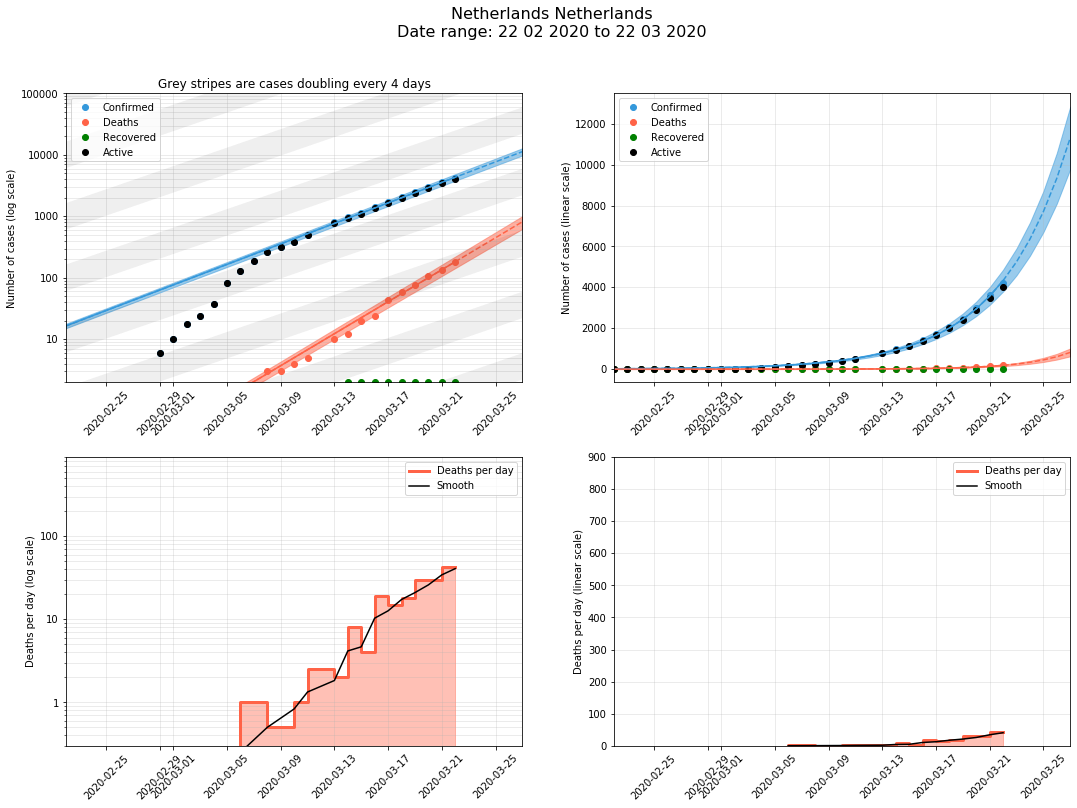

In [28]:
display(Markdown("## Netherlands"))
min_y1 = {'Confirmed': 10, 'Deaths': 4, 'Recovered': 0}
do_debug=False
fits_todo1 = {'Confirmed': [func_exponential],
             'Deaths':     [func_exponential],
             'Recovered':  [func_exponential, func_logistic]}

my_country = select_country(data, country='Netherlands',province='Netherlands', start_date='2020-02-22')
data_country, prediction = fit_data(my_country, min_y=min_y1, fits_todo=fits_todo1)
fig, ax = plot_country(data_country, prediction)
print_table(my_country, prediction, days=5)


## Poland

#### Current today

Date (end of),Confirmed,Deaths,Recovered
Sun 22 March 2020,634,7,1


#### 5 day prediction

Date (end of),Confirmed,Deaths,Recovered
Mon 23 March 2020,835,9,nan
Tue 24 March 2020,1054,10,nan
Wed 25 March 2020,1330,12,nan
Thu 26 March 2020,1679,14,nan
Fri 27 March 2020,2120,16,nan


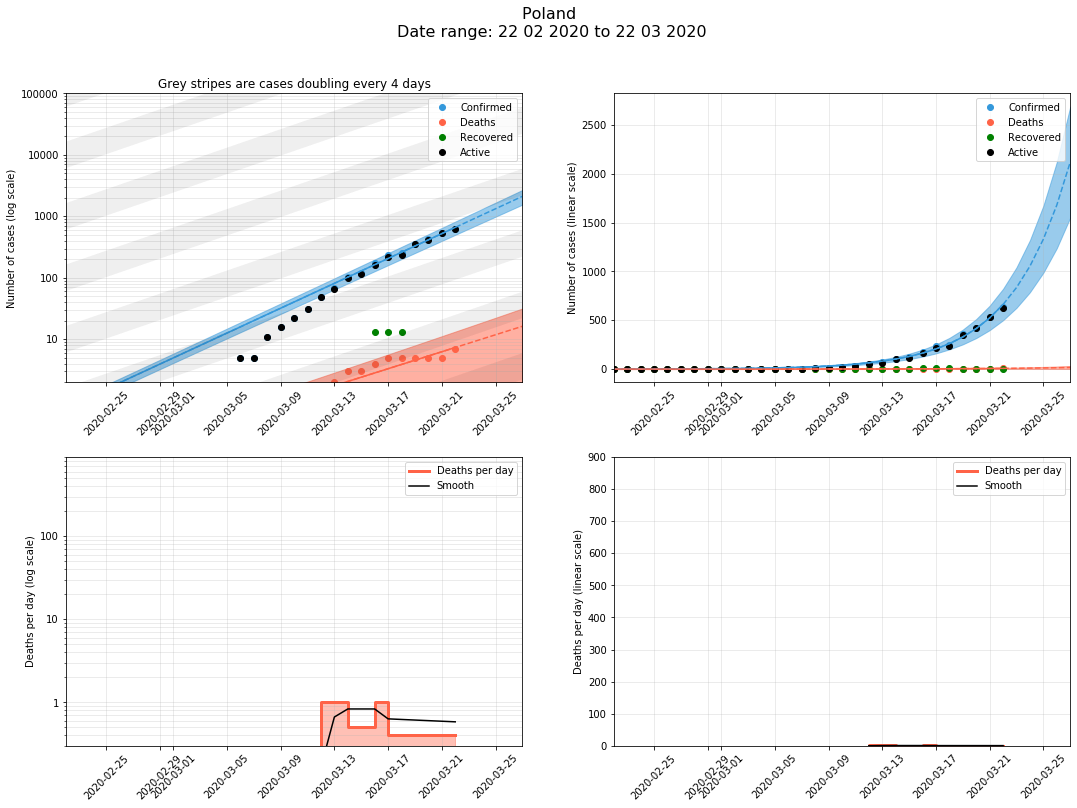

In [29]:
display(Markdown("## Poland"))
min_y1 = {'Confirmed': 10, 'Deaths': 1, 'Recovered': 0}
do_debug=False
fits_todo1 = {'Confirmed': [func_exponential],
             'Deaths':     [func_exponential],
             'Recovered':  [func_exponential, func_logistic]}

my_country = select_country(data, country='Poland',province='', start_date='2020-02-22')
data_country, prediction = fit_data(my_country, min_y=min_y1, fits_todo=fits_todo1)
fig, ax = plot_country(data_country, prediction)
print_table(my_country, prediction, days=5)


## Switzerland

#### Current today

Date (end of),Confirmed,Deaths,Recovered
Sun 22 March 2020,7245,98,131


#### 5 day prediction

Date (end of),Confirmed,Deaths,Recovered
Mon 23 March 2020,9424,130,nan
Tue 24 March 2020,11623,174,nan
Wed 25 March 2020,14336,231,nan
Thu 26 March 2020,17681,308,nan
Fri 27 March 2020,21807,410,nan


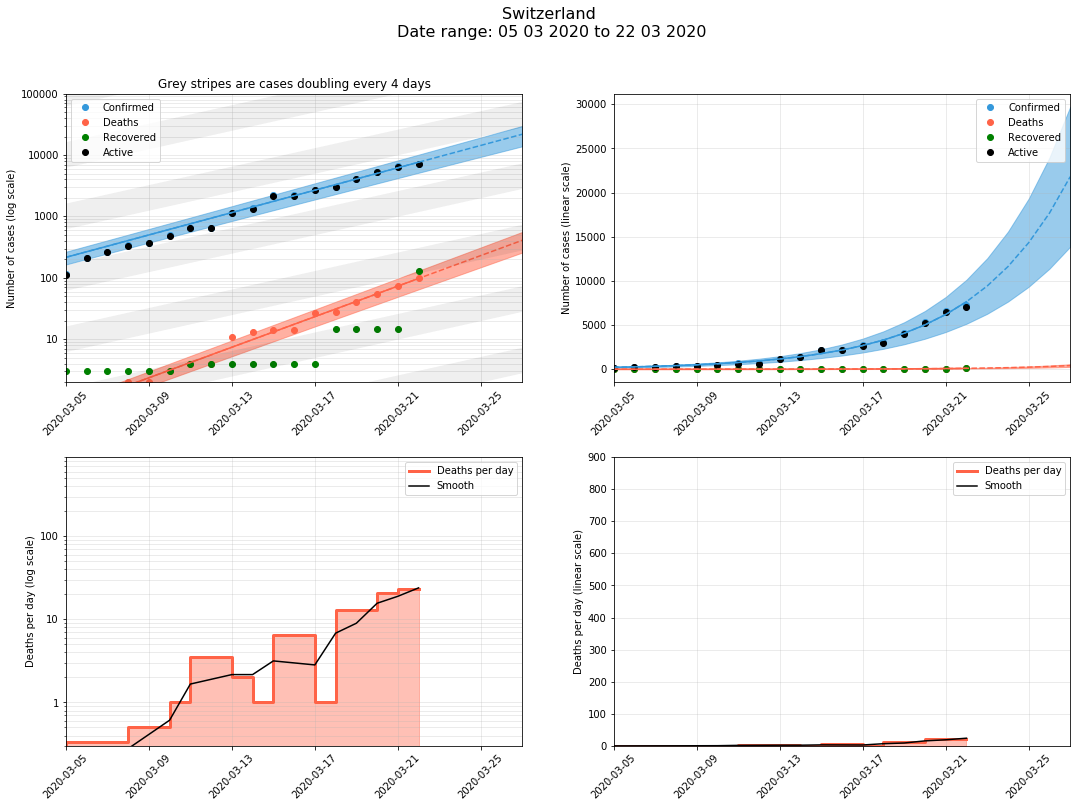

In [30]:
display(Markdown("## Switzerland"))
min_y1 = {'Confirmed': 10, 'Deaths': 5, 'Recovered': 0}
do_debug=False
fits_todo1 = {'Confirmed': [func_exponential],
             'Deaths':     [func_exponential],
             'Recovered':  [func_exponential]}

my_country = select_country(data, country='Switzerland',province='', start_date='2020-03-05')
data_country, prediction = fit_data(my_country, min_y=min_y1, fits_todo=fits_todo1)
fig, ax = plot_country(data_country, prediction)
print_table(my_country, prediction, days=5)


## Belgium

#### Current today

Date (end of),Confirmed,Deaths,Recovered
Sun 22 March 2020,3401,75,263


#### 5 day prediction

Date (end of),Confirmed,Deaths,Recovered
Mon 23 March 2020,4197,120,546
Tue 24 March 2020,5154,178,1015
Wed 25 March 2020,6330,263,1890
Thu 26 March 2020,7775,390,3518
Fri 27 March 2020,9549,577,6547


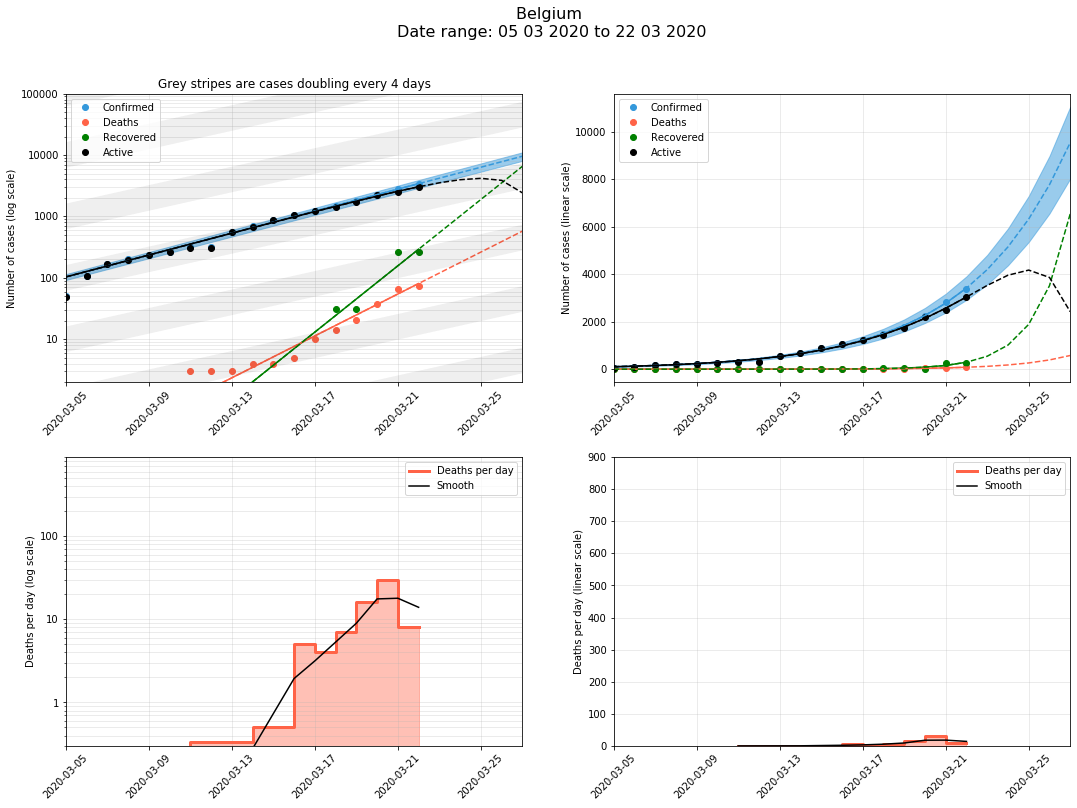

In [31]:
display(Markdown("## Belgium"))
min_y1 = {'Confirmed': 10, 'Deaths': 5, 'Recovered': 0}
do_debug=False
fits_todo1 = {'Confirmed': [func_exponential],
             'Deaths':     [func_exponential],
             'Recovered':  [func_exponential]}

my_country = select_country(data, country='Belgium',province='', start_date='2020-03-05')
data_country, prediction = fit_data(my_country, min_y=min_y1, fits_todo=fits_todo1)
fig, ax = plot_country(data_country, prediction)
print_table(my_country, prediction, days=5)


# United States

I use the combined data for all the states combined

#### Current today

Date (end of),Confirmed,Deaths,Recovered
Sun 22 March 2020,33272,417,0


#### 5 day prediction

Date (end of),Confirmed,Deaths,Recovered
Mon 23 March 2020,46799,527,nan
Tue 24 March 2020,64366,682,nan
Wed 25 March 2020,88529,883,nan
Thu 26 March 2020,121762,1142,nan
Fri 27 March 2020,167470,1477,nan


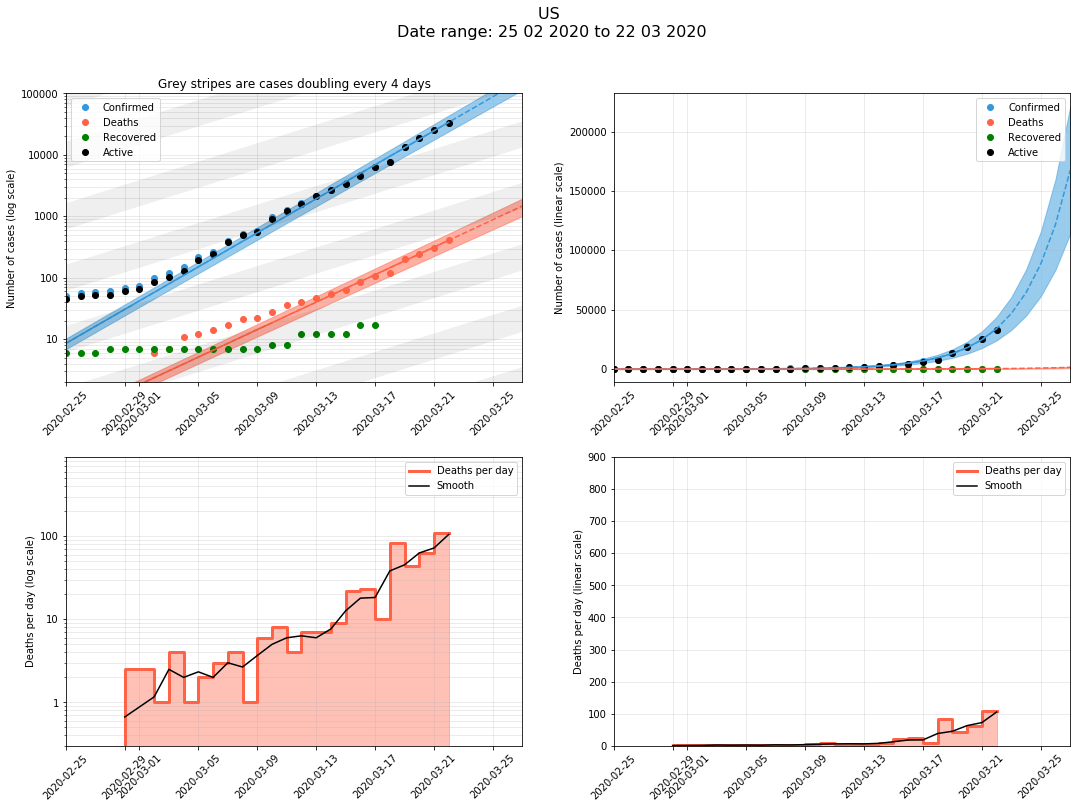

In [32]:
per_country = data.groupby(['DateTime','Country/Region']).sum().reset_index()
usa = per_country[per_country['Country/Region']=='US']
usa['Province/State'] = ''
min_y1 = {'Confirmed': 50, 'Deaths': 0, 'Recovered': 0}
fits_todo1 = {'Confirmed': [func_exponential],
             'Deaths':     [func_exponential],
             'Recovered':  [func_exponential]}

my_country = select_country(usa, country='US', province='', start_date='2020-02-25')
data_country, prediction = fit_data(my_country, min_y=min_y1, fits_todo=fits_todo1)
fig, ax = plot_country(data_country, prediction)
print_table(my_country, prediction, days=5)

# Comparison of different countries

In [33]:
def compare_countries2(data, countries, lw1=4, name='comparison'):
    gridsize = (3, 2)
    fig = plt.figure(figsize=(16, 12))
    ax1 = plt.subplot2grid(gridsize, (0, 0))
    ax2 = plt.subplot2grid(gridsize, (1, 0))
    ax3 = plt.subplot2grid(gridsize, (2, 0))
    #ax4 = plt.subplot2grid(gridsize, (3, 0))
    ax1b = plt.subplot2grid(gridsize, (0, 1))
    ax2b = plt.subplot2grid(gridsize, (1, 1))
    ax3b = plt.subplot2grid(gridsize, (2, 1))
    #ax4b = plt.subplot2grid(gridsize, (3, 1))
    plt.subplots_adjust(hspace=0)

    for country in countries.keys():
        c = countries[country]
        my_country = select_country(data,
                                    country=c['country'],
                                    province=c.get('province', ''),
                                    start_date=c.get('start_date', '2020-02-15'),
                                    end_date=c.get('end_date', '2021-01-01'))
        data_country1, prediction1 = fit_data(my_country)

        symbol='x'
        l = ax1.plot(data_country1['DateTime']+datetime.timedelta(days=c['delay']), data_country1['Confirmed'], symbol)
        l = ax1.plot(data_country1['DateTime']+datetime.timedelta(days=c['delay']), data_country1['Confirmed_fit'], '-', color=l[0].get_color(), lw=lw1, label=f'{country} ({c["delay"]}d)')
        l = ax1.plot(prediction1['DateTime']  +datetime.timedelta(days=c['delay']), prediction1['Confirmed_pred'], '--', color=l[0].get_color())
        l = ax2.plot(data_country1['DateTime']+datetime.timedelta(days=c['delay']), data_country1['Deaths'], symbol)
        l = ax2.plot(data_country1['DateTime']+datetime.timedelta(days=c['delay']), data_country1['Deaths_fit'], '-', color=l[0].get_color(), lw=lw1, label=f'{country} ({c["delay"]}d)')
        l = ax2.plot(prediction1['DateTime']  +datetime.timedelta(days=c['delay']), prediction1['Deaths_pred'], '--', color=l[0].get_color())
        l = ax3.plot(data_country1['DateTime']+datetime.timedelta(days=c['delay']), data_country1['Recovered'], symbol)
        l = ax3.plot(data_country1['DateTime']+datetime.timedelta(days=c['delay']), data_country1['Recovered_fit'], '-', color=l[0].get_color(), lw=lw1, label=f'{country} ({c["delay"]}d)')
        l = ax3.plot(prediction1['DateTime']  +datetime.timedelta(days=c['delay']), prediction1['Recovered_pred'], '--', color=l[0].get_color())
        
        l = ax1b.plot(data_country1['DateTime']+datetime.timedelta(days=c['delay']), data_country1['Confirmed'], symbol)
        l = ax1b.plot(data_country1['DateTime']+datetime.timedelta(days=c['delay']), data_country1['Confirmed_fit'], '-', color=l[0].get_color(), lw=lw1, label=f'{country} ({c["delay"]}d)')
        l = ax1b.plot(prediction1['DateTime']  +datetime.timedelta(days=c['delay']), prediction1['Confirmed_pred'], '--', color=l[0].get_color())
        l = ax2b.plot(data_country1['DateTime']+datetime.timedelta(days=c['delay']), data_country1['Deaths'], symbol)
        l = ax2b.plot(data_country1['DateTime']+datetime.timedelta(days=c['delay']), data_country1['Deaths_fit'], '-', color=l[0].get_color(), lw=lw1, label=f'{country} ({c["delay"]}d)')
        l = ax2b.plot(prediction1['DateTime']  +datetime.timedelta(days=c['delay']), prediction1['Deaths_pred'], '--', color=l[0].get_color())
        l = ax3b.plot(data_country1['DateTime']+datetime.timedelta(days=c['delay']), data_country1['Recovered'], symbol)
        l = ax3b.plot(data_country1['DateTime']+datetime.timedelta(days=c['delay']), data_country1['Recovered_fit'], '-', color=l[0].get_color(), lw=lw1, label=f'{country} ({c["delay"]}d)')
        l = ax3b.plot(prediction1['DateTime']  +datetime.timedelta(days=c['delay']), prediction1['Recovered_pred'], '--', color=l[0].get_color())
       
        
    #ax3.set_ylim(0, np.max(data_country['Deaths'])*1.5)
    #ax2.set_ylim(0,1e5)
    #ax1.set_ylim(0.5,1e5)

    ax1.set_ylabel('Confirmed')
    ax2.set_ylabel('Deaths')
    ax3.set_ylabel('Recovered')
    
    for ax in [ax1,ax2,ax1b,ax2b]:
        ax.xaxis.set_ticklabels([])
    ax3.xaxis.set_tick_params(rotation=45)
    ax3b.xaxis.set_tick_params(rotation=45)
    ax1.set_title('Log scale')
    ax1b.set_title('Linear scale')
    #fig.suptitle(f'{country} {province}\nDate range: {start_date} to {end_date}', fontsize=16)

    for ax in [ax1,ax2,ax3]:
        ax.set_yscale('log')
    
    for ax in [ax1,ax2,ax3,ax1b,ax2b,ax3b]:
        ax.set_ylim(0.5,)
        ax.legend()
        
    fig.savefig(f'./plots/{name}.png', bbox_inches='tight', dpi=100)
        

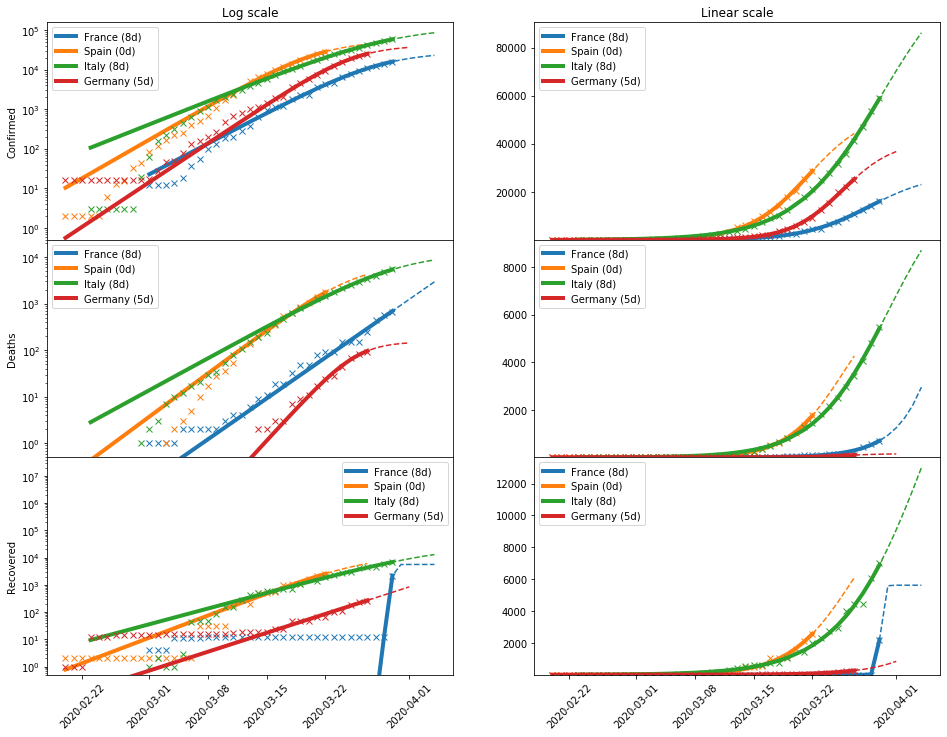

In [34]:
countries = {
    'France': {'country': 'France', 'province': 'France', 'start_date':'2020-02-22', 'end_date':'2021-01-01', 'delay': 8},
    'Spain': {'country': 'Spain', 'start_date':'2020-02-20', 'end_date':'2021-01-01', 'delay': 0},
    'Italy': {'country': 'Italy', 'start_date':'2020-02-15', 'end_date':'2021-01-01', 'delay': 8},
    'Germany': {'country': 'Germany', 'start_date':'2020-02-15', 'end_date':'2021-01-01', 'delay': 5},

}
compare_countries2(data, countries, name='comparison1')

## Early onset: China regions

Most of the regions have almost completed the cycle and active cases are disappearing. Note that China Hubei (the original area) has a large number of confirmed cases (70000), but the other regions have very low number of cases, with number around 1200-500 or even less.

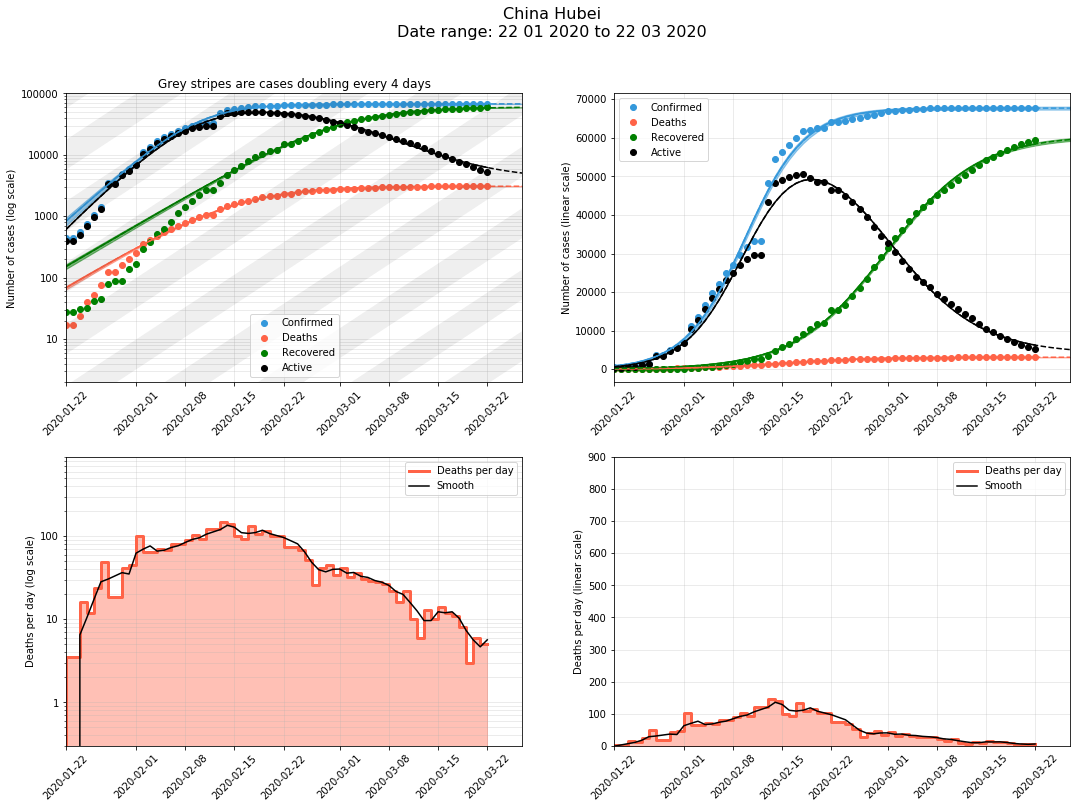

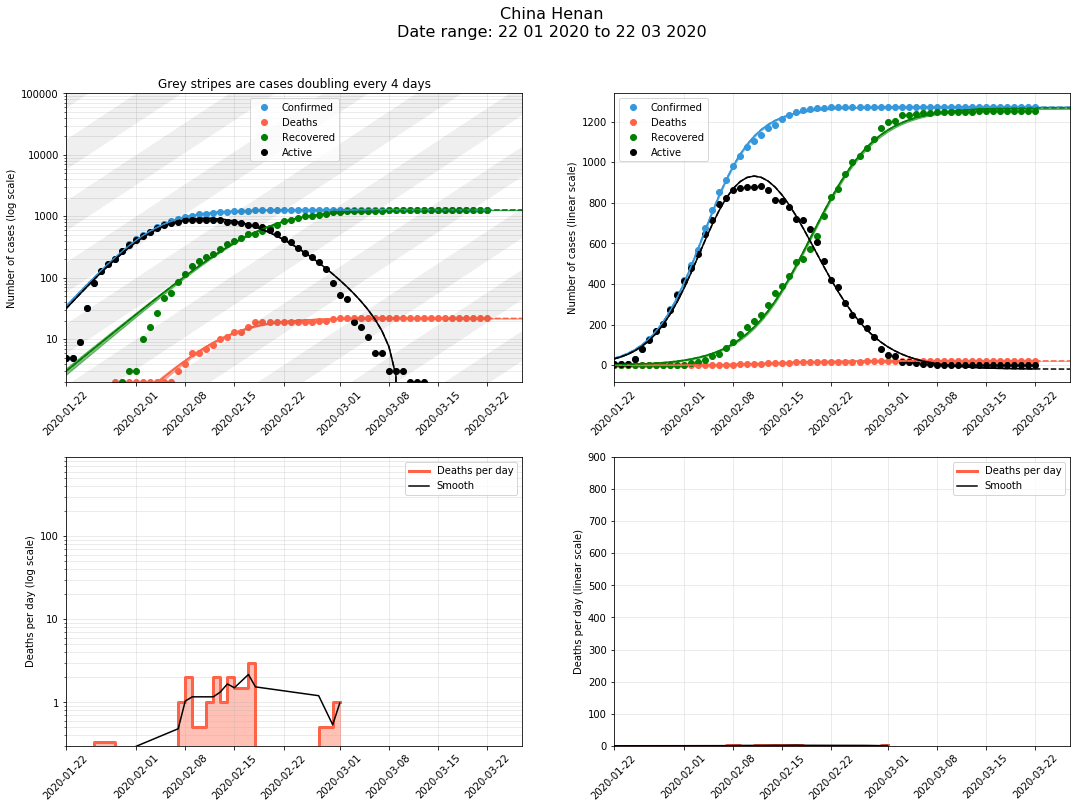

In [35]:
idx = data.groupby(['Country/Region', 'Province/State'])[['Confirmed','Deaths']].sum().sort_values(by='Deaths')[::-1][0:10].index
for i in idx:
    country, province = i
    if country == 'China':
        data_country, prediction, fig, ax = process_country(data, country=country, province=province)

## Other countries in Asia

South Korea has a remarkable recovery rate, with many cases and a reduced number of deaths. Japan growth is moderate, much smaller than in European countries. Iran is showing hints of flattening, although it is curious that the number of recoveries has significantly slowed down while the number of deaths still follow a very exponential trend.


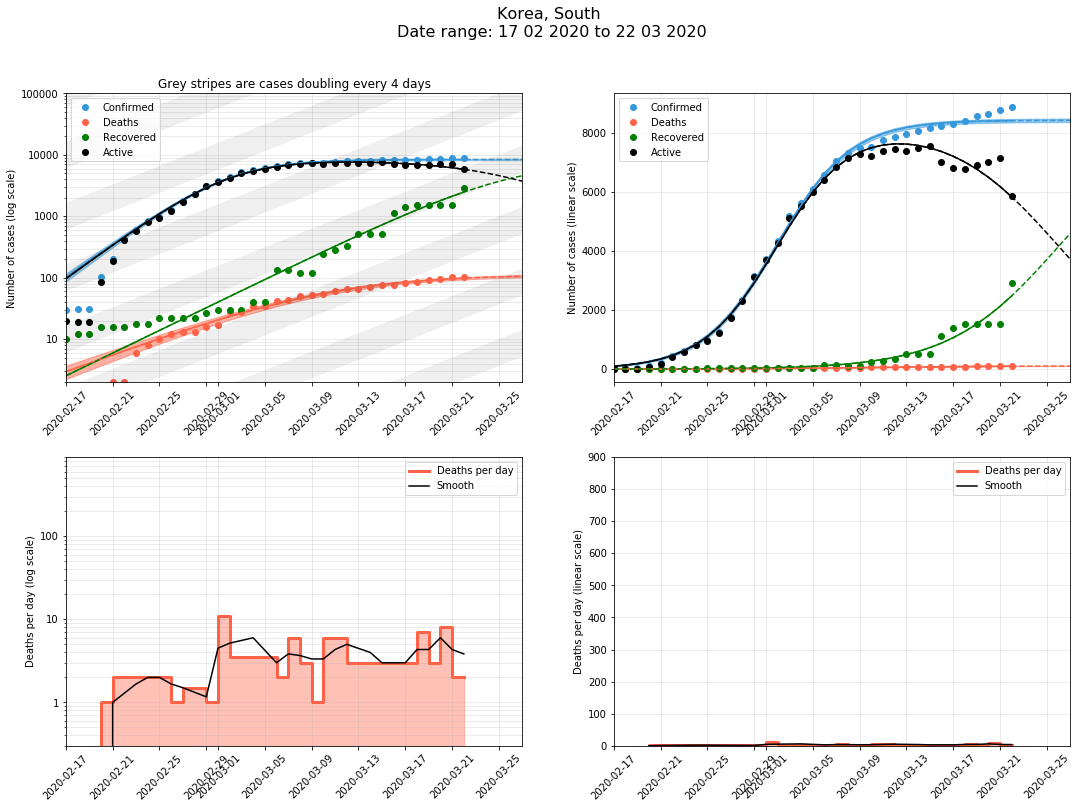

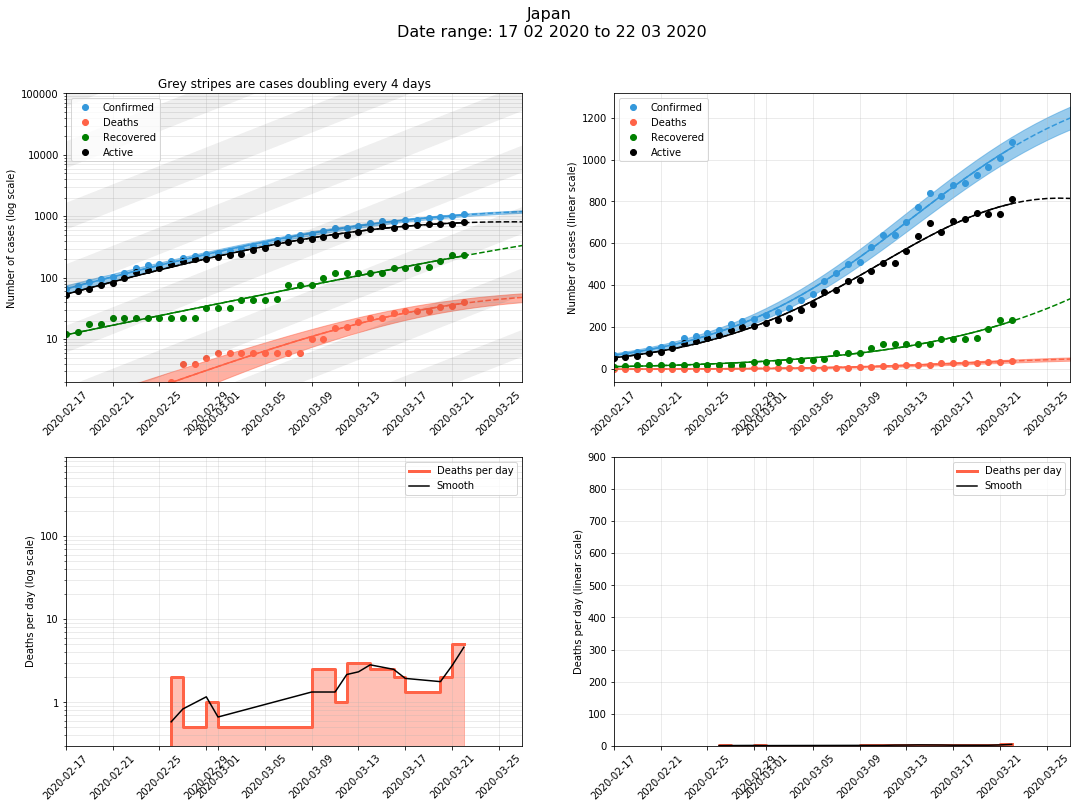

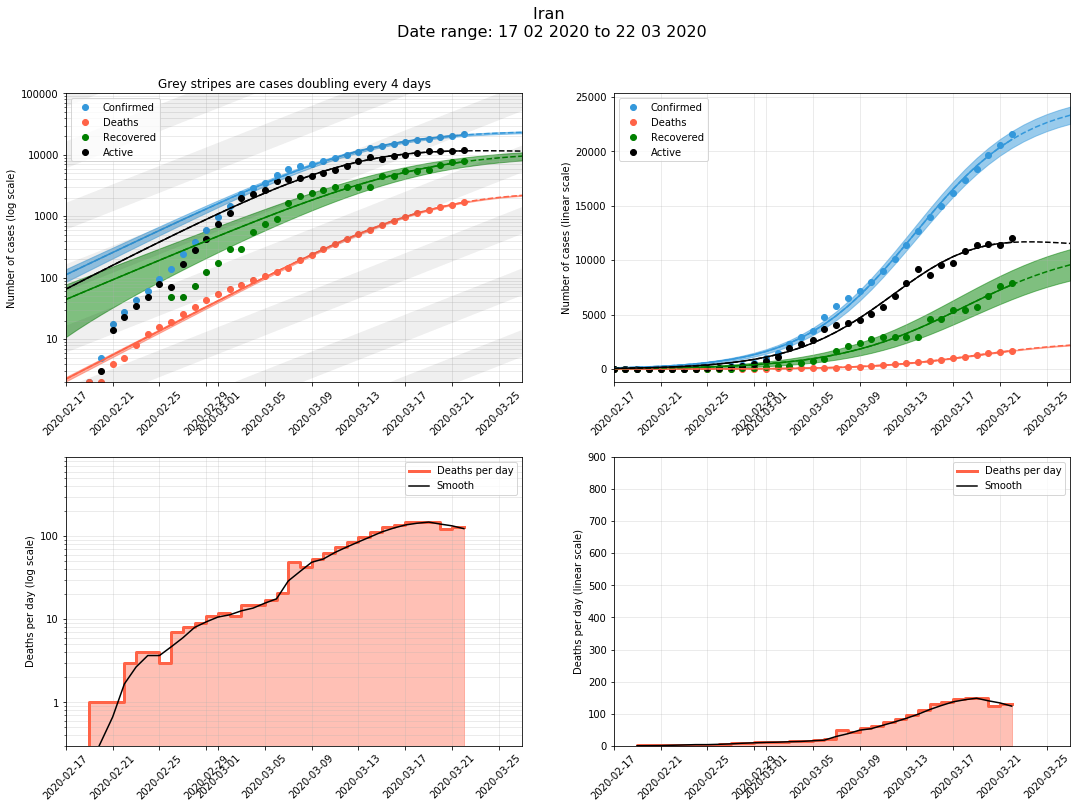

In [36]:
europe_list = [
    ['Korea, South', ''],
    ['Japan', ''],
    ['Iran', '']
]
for country, province in europe_list:
    data_country, prediction, fig, ax = process_country(data, country=country, province=province, start_date='2020-02-17')